In [1]:
!pip install transformers
import torch
import torchvision
import torchvision.transforms as transforms
from transformers import CLIPTokenizer, CLIPTextModel
from torch import nn, optim
from torch.utils.data import DataLoader
import numpy as np


In [2]:
# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # resize to match CLIP's input
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

# Initialize a list of CIFAR-100 labels as text prompts
cifar_labels = trainset.classes  # CIFAR-100 classes as labels


100%|██████████| 169M/169M [00:06<00:00, 25.3MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [3]:
# Load text model and tokenizer from transformers
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")

# Define the image encoder (using a pre-trained ResNet)
image_encoder = torchvision.models.resnet50(pretrained=True)
image_encoder.fc = nn.Linear(image_encoder.fc.in_features, 512)  # Modify to output 512-dimensional embeddings

# Define the multimodal model
class MultiModalModel(nn.Module):
    def __init__(self, image_encoder, text_model):
        super(MultiModalModel, self).__init__()
        self.image_encoder = image_encoder
        self.text_encoder = text_model

    def forward(self, images, input_ids, attention_mask):
        # Encode image
        image_embeddings = self.image_encoder(images)

        # Encode text
        text_output = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embeddings = text_output.last_hidden_state[:, 0, :]  # CLS token

        return image_embeddings, text_embeddings

model = MultiModalModel(image_encoder, text_model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 131MB/s]


MultiModalModel(
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Printing CIFAR DATA and test to connect it with description

Files already downloaded and verified


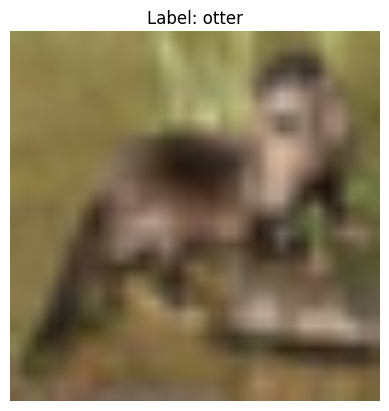

TypeError: MultiModalModel.forward() missing 2 required positional arguments: 'input_ids' and 'attention_mask'

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import torchvision.transforms as transforms
from transformers import CLIPTokenizer, CLIPTextModel
import torchvision
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_documents = [
    "This image depicts a cat sitting on a chair.",
    "This is an image of a dog playing with a ball.",
    # Add more descriptive texts corresponding to images
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
def encode_question(question):
    inputs = tokenizer(question, return_tensors="pt", padding=True, truncation=True).to(device)
    text_output = model.text_encoder(**inputs)
    return text_output.last_hidden_state[:, 0, :]  # CLS token for representation

def get_best_match(question_embedding, image_embeddings, text_embeddings):
    # Calculate cosine similarities
    image_similarities = nn.functional.cosine_similarity(question_embedding, image_embeddings)
    text_similarities = nn.functional.cosine_similarity(question_embedding, text_embeddings)

    # Get indices of the best matches
    best_image_idx = torch.argmax(image_similarities).item()
    best_text_idx = torch.argmax(text_similarities).item()

    return best_image_idx, best_text_idx

def answer_question(question, images):
    # Encode the question
    question_embedding = encode_question(question)

    # Generate embeddings for the images
    with torch.no_grad():
        image_embeddings, text_embeddings = model(images)

    # Get the best matching indices
    best_image_idx, best_text_idx = get_best_match(question_embedding, image_embeddings, text_embeddings)

    # Retrieve answers
    image_answer = f"Image answer from index {best_image_idx}" if best_image_idx >= 0 else None
    text_answer = text_documents[best_text_idx] if best_text_idx < len(text_documents) else None

    return image_answer, text_answer


# Ask a question
question = "What animal is in the image?"
# Example usage
index = 100  # Change index to view different images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match CLIP's input size
    transforms.ToTensor(),
])
cifar_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
sample_image, label = cifar_dataset[index]
label_name = cifar_dataset.classes[label]
# Display the selected image
import matplotlib.pyplot as plt
plt.imshow(sample_image.permute(1, 2, 0))
plt.title(f"Label: {label_name}")
plt.axis("off")
plt.show()

# Get the answer
image_answer, text_answer = answer_question(question, sample_image)

print("Image Answer:", image_answer)
print("Text Answer:", text_answer)

Read all data available in CIFAR100

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import torchvision.transforms as transforms
from transformers import CLIPTokenizer, CLIPTextModel
import torchvision
# Load CIFAR-100 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)

# Generate synthetic image names
image_names = []
for i in range(len(trainset)):
    image, label = trainset[i]
    label_name = trainset.classes[label]
    image_name = f"{label_name}_{i}.png"  # Generate a name based on label and index
    image_names.append(image_name)

# Display some example names
print(image_names[:10])  #

Files already downloaded and verified
['cattle_0.png', 'dinosaur_1.png', 'apple_2.png', 'boy_3.png', 'aquarium_fish_4.png', 'telephone_5.png', 'train_6.png', 'cup_7.png', 'cloud_8.png', 'elephant_9.png']


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Files already downloaded and verified


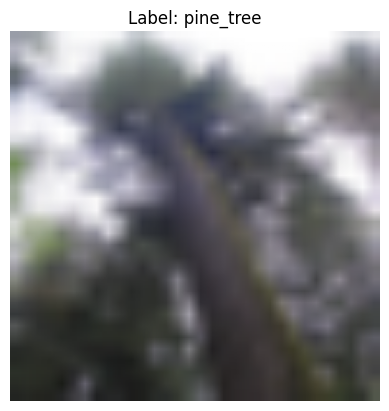

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import torchvision.transforms as transforms
from transformers import CLIPTokenizer, CLIPTextModel
import torchvision
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)

# Load CIFAR-100 dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match CLIP's input size
    transforms.ToTensor(),
])
cifar_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
 #Example usage
index = 24  # Change index to view different images
sample_image, label = cifar_dataset[index]
label_name = cifar_dataset.classes[label]
sample_text = f"This is a {label_name} belonging to the category of animal. It has four legs and brown color"

# Display the selected image
import matplotlib.pyplot as plt
plt.imshow(sample_image.permute(1, 2, 0))
plt.title(f"Label: {label_name}")
plt.axis("off")
plt.show()

#CLIP


In [ ]:
!pip install torch torchvision transformers


Read both text and image data


In [ ]:
import torch
import clip
from PIL import Image

# Check for GPU and load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load and preprocess an image
image_path = "bike_image.png"  # Replace with the actual path to your image
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

# Define a few text descriptions for zero-shot matching
text_descriptions = ["A photo of a bicycle with 21 gears.",
                     "A red mountain bike.",
                     "A bike with a basket."]

# Tokenize text descriptions
text_inputs = clip.tokenize(text_descriptions).to(device)

# Generate embeddings
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)

# Normalize features for cosine similarity
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Calculate cosine similarities
similarities = (image_features @ text_features.T).squeeze(0)

# Output the best match
best_match_idx = similarities.argmax().item()
print("Best matching description:", text_descriptions[best_match_idx])


100%|███████████████████████████████████████| 338M/338M [00:29<00:00, 12.2MiB/s]


Best matching description: A red mountain bike.


In [ ]:
# Install the CLIP library if not already installed
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision Pillow

# Import required libraries
import torch
import clip
from PIL import Image

# Check for GPU and load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load and preprocess the image
image_path = "bike_image.png"  # Replace with the actual path to your image
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

# Define a few text descriptions for zero-shot matching
text_descriptions = [
    "A photo of a bicycle with 21 gears.",
    "A red mountain bike.",
    "A bike with a basket."
]

# Tokenize and encode text descriptions
text_inputs = clip.tokenize(text_descriptions).to(device)
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)

# Normalize the features for cosine similarity
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Calculate similarity between image and text
similarities = (image_features @ text_features.T).squeeze(0)

# Output the best matching description
best_match_idx = similarities.argmax().item()
print("Best matching description:", text_descriptions[best_match_idx])

# Sample question for Q&A
question = "color of bike?"
question_embedding = model.encode_text(clip.tokenize([question]).to(device))

# Compute similarity with text descriptions
question_embedding /= question_embedding.norm(dim=-1, keepdim=True)
question_similarity = (question_embedding @ text_features.T).squeeze(0)
question_image_similarity = (question_embedding @ image_features.T).squeeze(0)
# Find and print the best answer
best_answer_idx = question_similarity.argmax().item()
best_answer_idx_image = question_image_similarity.argmax().item()
print("Answer:", text_descriptions[best_answer_idx])
print("Answer image:", text_descriptions[best_answer_idx_image])

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-k014m_sp
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-k014m_sp
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
Best matching description: A red mountain bike.
Answer: A bike with a basket.
Answer image: A photo of a bicycle with 21 gears.


Only 76 token used

In [ ]:
# Install necessary libraries
!pip install git+https://github.com/openai/CLIP.git
!pip install openai==0.28
!pip install torch torchvision Pillow openai

# Import required libraries
import torch
import clip
from PIL import Image
import openai

# Set your OpenAI API key
openai.api_key = "****"  # add your openai apikey

# Check for GPU and load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
#model, preprocess = clip.load("ViT-B/32", device=device)

# Load and preprocess the image
image_path = "bike_image.png"  # Replace with the actual path to your image
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

# Define text descriptions
text_descriptions = [
   "This red bicycle is a sleek and sturdy mountain bike designed for both style and functionality. Its vibrant red frame is complemented by black handlebars"

]

# Tokenize and encode text descriptions
text_inputs = clip.tokenize(text_descriptions).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Function to generate image description using CLIP
def describe_image(image, text_descriptions):
    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarities = (image_features @ text_features.T).squeeze(0)
        best_match_idx = similarities.argmax().item()
        return text_descriptions[best_match_idx]

# Function to interact with GPT for dynamic intent and answer generation
def generate_answer_with_gpt(question, image_description, text_descriptions):
    # Combine question, image description, and text descriptions
    prompt = f"""
    You are an AI assistant with vision-language capabilities.
    Here is an image description: "{image_description}".
    Here are some text descriptions of the image: {text_descriptions}.
    Now, answer the following question based on the image and text: "{question}".
    If the text descriptions don't contain the answer, infer from the image.
    """

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}]
    )

    return response["choices"][0]["message"]["content"].strip()

# Main function to process the question
def answer_question(question):
    # Step 1: Get the best image description
    image_description = describe_image(image, text_descriptions)
    print(f"Image Description: {image_description}")

    # Step 2: Generate the answer dynamically
    answer = generate_answer_with_gpt(question, image_description, text_descriptions)
    return answer

# Example question
question = "What is the feature of the bike?"
print("Answer:", answer_question(question))


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6p90xyje
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6p90xyje
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.4
    Uninstalling openai-1.54.4:
      Successfully uninstalled openai-1.54.4
Image Description: This red bicycle is a sleek and sturdy mountain bike designed for both style and functionality. Its vibrant red frame is complemented by black handlebars
Answer: The bike is sleek and sturdy, designed for both style and functionality. It has a vibrant red frame and black handlebars.


Final version{ overpassing 76 token limit to clip limit. By chunking and appending the chunks}

In [5]:
# Install necessary libraries
!pip install git+https://github.com/openai/CLIP.git
!pip install openai==0.28
!pip install torch torchvision Pillow openai scikit-learn opencv-python

# Import required libraries
import torch
import clip
from PIL import Image
import openai
import numpy as np
import cv2
from sklearn.cluster import KMeans

# Set your OpenAI API key
openai.api_key = "*******" # add your openai apikey

# Check for GPU and load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load and preprocess the image
image_path = "/content/bike_image-removebg-preview.png"  # Replace with the actual path to your image
image = Image.open(image_path)
image_for_clip = preprocess(image).unsqueeze(0).to(device)


def extract_dominant_color(image, n_colors=1):
    # Convert image to BGR (for OpenCV)
    image_bgr = np.array(image.convert('RGB'))[:, :, ::-1]  # RGB to BGR
    # Resize image for faster processing
    image_bgr_resized = cv2.resize(image_bgr, (image_bgr.shape[1] // 2, image_bgr.shape[0] // 2))
    # Reshape to a 2D array of pixels
    pixels = image_bgr_resized.reshape(-1, 3)
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_colors, random_state=0)
    kmeans.fit(pixels)
    # Return the dominant color
    dominant_color = kmeans.cluster_centers_.astype(int)[0]
    return tuple(dominant_color)


# Extract the dominant color from the image
dominant_color = extract_dominant_color(image)
color_str = f"the dominant color is rgb({dominant_color[0]}, {dominant_color[1]}, {dominant_color[2]})"

# Define text descriptions (Ensure the text description is dynamic with the color)
text_descriptions = [
    f"This is a bicycle with {color_str}. It's designed for both style and functionality, "
    "with a sleek frame, ergonomic grips, and high-performance tires for all-terrain usage."
]

# Function to split long text into smaller chunks
def split_text_into_chunks(text, max_tokens=76):
    words = text.split()
    chunks = []
    current_chunk = []

    for word in words:
        if len(clip.tokenize(" ".join(current_chunk + [word]))[0]) <= max_tokens:
            current_chunk.append(word)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [word]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

# Split text descriptions into chunks
chunked_text_descriptions = []
for description in text_descriptions:
    chunked_text_descriptions.extend(split_text_into_chunks(description))

# Tokenize and encode all text chunks
text_inputs = clip.tokenize(chunked_text_descriptions).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Function to describe image using CLIP (now considering the dominant color)
def describe_image(image, text_features, chunked_text_descriptions):
    with torch.no_grad():
        # Encode the image
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Calculate the similarities between image and text features
        similarities = (image_features @ text_features.T).squeeze(0)
        best_match_idx = similarities.argmax().item()

        # Return the description corresponding to the highest similarity
        return chunked_text_descriptions[best_match_idx]

# Function to interact with GPT for dynamic intent and answer generation
def generate_answer_with_gpt(question, image_description, text_descriptions):
    # Combine question, image description, and text descriptions
    prompt = f"""
    You are an AI assistant with vision-language capabilities.
    Here is an image description: "{image_description}".
    Here are some text descriptions of the image: {text_descriptions}.
    Now, answer the following question based on the image and text: "{question}".
    If the text descriptions don't contain the answer, infer from the image.
    """

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}]
    )

    return response["choices"][0]["message"]["content"].strip()

# Main function to process the question
def answer_question(question):
    # Step 1: Get the best image description
    image_description = describe_image(image_for_clip, text_features, chunked_text_descriptions)
    print(f"Image Description: {image_description}")

    # Step 2: Generate the answer dynamically
    answer = generate_answer_with_gpt(question, image_description, text_descriptions)
    return answer

# Example question to check for color
question = "What is this object in the image and tell me about its grips?"
print("Answer:", answer_question(question))


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qzfngc0u
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qzfngc0u
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
Image Description: bicycle
Answer: The object in the image is a bicycle. As per the text description, it has ergonomic grips designed for comfortable riding.


Test code

In [2]:
!pip install git+https://github.com/openai/CLIP.git
!pip install openai==0.28
!pip install torch torchvision Pillow openai scikit-learn opencv-python

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4ipr_6qa
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4ipr_6qa
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=fabc0a14db96f83088c097d76dd03d7e5bcabcbc6c096aea4f7d08c6109fb086
  Stored in directory: /tmp/pip-ephem-wheel-cache-kbt31gxt/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.4
    Uninstalling openai-1.54.4:
      Successfully uninstalled openai-1.54.4


In [9]:
pip install transformers


In [22]:
import torch
import clip
from PIL import Image
import numpy as np
import cv2
from sklearn.cluster import KMeans
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Check for GPU and load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load and preprocess the image
image_path = "/content/bike_image-removebg-preview.png"  # Replace with the actual path to your image
image = Image.open(image_path)
image_for_clip = preprocess(image).unsqueeze(0).to(device)

def extract_dominant_color(image, n_colors=1):
    # Convert image to BGR (for OpenCV)
    image_bgr = np.array(image.convert('RGB'))[:, :, ::-1]  # RGB to BGR
    # Resize image for faster processing
    image_bgr_resized = cv2.resize(image_bgr, (image_bgr.shape[1] // 2, image_bgr.shape[0] // 2))
    # Reshape to a 2D array of pixels
    pixels = image_bgr_resized.reshape(-1, 3)
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_colors, random_state=0)
    kmeans.fit(pixels)
    # Return the dominant color
    dominant_color = kmeans.cluster_centers_.astype(int)[0]
    return tuple(dominant_color)

# Extract the dominant color from the image
dominant_color = extract_dominant_color(image)
color_str = f"the dominant color is rgb({dominant_color[0]}, {dominant_color[1]}, {dominant_color[2]})"

# Define text descriptions (Ensure the text description is dynamic with the color)
text_descriptions = [
    f"This is a bicycle with {color_str}. It's designed for both style and functionality, "
    "with a sleek frame, ergonomic grips, and high-performance tires for all-terrain usage."
]

# Function to split long text into smaller chunks
def split_text_into_chunks(text, max_tokens=76):
    words = text.split()
    chunks = []
    current_chunk = []

    for word in words:
        if len(clip.tokenize(" ".join(current_chunk + [word]))[0]) <= max_tokens:
            current_chunk.append(word)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [word]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

# Split text descriptions into chunks
chunked_text_descriptions = []
for description in text_descriptions:
    chunked_text_descriptions.extend(split_text_into_chunks(description))

# Tokenize and encode all text chunks
text_inputs = clip.tokenize(chunked_text_descriptions).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# Function to describe image using CLIP
def describe_image(image, text_features, chunked_text_descriptions):
    with torch.no_grad():
        # Encode the image
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Calculate the similarities between image and text features
        similarities = (image_features @ text_features.T).squeeze(0)
        best_match_idx = similarities.argmax().item()

        # Return the full description corresponding to the highest similarity
        return chunked_text_descriptions[best_match_idx]

# Load T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model_t5 = T5ForConditionalGeneration.from_pretrained('t5-small')
model_t5.to(device)
model_t5.eval()

# Function to generate answer with T5
def generate_answer_with_t5(question, image_description, text_descriptions):
    # Simplify and structure the prompt to avoid redundancy
    prompt = (
        f"Image description: {image_description}\n"
        f"Text descriptions: {' '.join(text_descriptions)}\n"
        f"Question: {question}\n"
        "Provide a clear and concise answer based on the image and text descriptions.\nAnswer:"
    )

    inputs = tokenizer(prompt, return_tensors='pt', padding='max_length', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model_t5.generate(
            inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=150,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id
        )

    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer_split = answer.split("Answer:")
    if len(answer_split) > 1:
        return answer_split[1].strip()
    else:
        return answer.strip()

# Main function to process the question
def answer_question(question):
    # Step 1: Describe the image
    image_description = describe_image(image_for_clip, text_features, chunked_text_descriptions)
    print(f"Image Description: {image_description}")

    # Step 2: Generate an answer using T5
    answer = generate_answer_with_t5(question, image_description, text_descriptions)
    return answer

# Example question to check for color
question = "What is this object in the image and tell me about its grips?"
print("Answer:", answer_question(question))


Image Description: bicycle
Answer: : bicycle Text descriptions: bicycle Text descriptions: This is a bicycle with the dominant color is rgb(35, 39, 46). It's designed for both style and functionality, with a sleek frame, ergonomic grips, and high-performance tires for all-terrain usage.
